In [20]:
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Activation, Dense, Convolution2D, MaxPooling2D, Flatten, Lambda, Cropping2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [14]:
# load csv
def load_and_split_data(data_dir, test_size=0.2, file_names=None, load_three=False, steer_left=0.08, steer_right=0.04):
    files = []
    if file_names == None:  # if not assined, then using all the training data
        files = glob(data_dir + "*/*.csv")
    else:
        files = [(data_dir + f + "/driving_log.csv") for f in file_names]
    samples = []
    for f in files:
        with open(f) as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                steer_center = float(line[3])
                if load_three:
                    samples.append(["." + line[0][line[0].find("/data/"):], steer_center])
                    samples.append(["." + line[1][line[1].find("/data/"):], steer_center + steer_left])
                    samples.append(["." + line[2][line[2].find("/data/"):], steer_center - steer_right])
                else:
                    samples.append(["." + line[0][line[0].find("/data/"):], steer_center])
                    
    train_samples, validation_samples = train_test_split(samples, test_size=test_size)
    return train_samples, validation_samples

# the data generator
def generator(samples, batch_size=32, with_shuffle=True):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if with_shuffle:
            shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for sample in batch_samples:
                images.append(cv2.imread(sample[0]))
                angles.append(sample[1])
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train) if with_shuffle else (X_train, y_train)

In [15]:
# train_samples, validtion_samples = load_and_split_data("./data/", file_names=["0314", "0319-2"], load_three=True)
train_samples, validtion_samples = load_and_split_data("./data/", file_names=["0314"])
len(train_samples), len(validtion_samples)

(1928, 482)

In [16]:
train_samples[:10]

[['./data/0314/IMG/center_2017_03_14_22_22_09_996.jpg', -0.6282749],
 ['./data/0314/IMG/center_2017_03_14_22_20_45_147.jpg', 0.0],
 ['./data/0314/IMG/center_2017_03_14_22_22_02_467.jpg', -0.1526889],
 ['./data/0314/IMG/center_2017_03_14_22_23_03_817.jpg', 1.0],
 ['./data/0314/IMG/center_2017_03_14_22_20_23_902.jpg', 0.0],
 ['./data/0314/IMG/center_2017_03_14_22_21_43_656.jpg', -0.153012],
 ['./data/0314/IMG/center_2017_03_14_22_20_11_569.jpg', 0.102702],
 ['./data/0314/IMG/center_2017_03_14_22_22_09_107.jpg', 0.0],
 ['./data/0314/IMG/center_2017_03_14_22_21_09_411.jpg', 0.0],
 ['./data/0314/IMG/center_2017_03_14_22_21_27_939.jpg', -0.9796949]]

In [17]:
# test the generator
count = 0
for t, v in generator(train_samples, batch_size=10, with_shuffle=True):
    count += 1
    if count == 2:
        break
    print(count, len(t), t[0].shape)

1 10 (160, 320, 3)


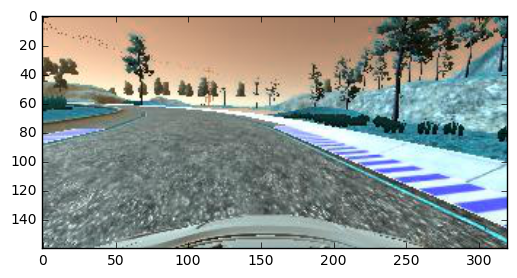

In [18]:
plt.imshow(t[0])

In [19]:
[v[i] for i in range(3)]

[0.0, 0.0, 0.0]

In [23]:
# the Nivida Paper 
# (http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) 
# 
def Nivdia():
    model = Sequential()
    model.add(Lambda(lambda x : x/255.0 - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    
    model.add(Convolution2D(3, 5, 5, border_mode="valid", activation="relu"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.5))

    model.add(Convolution2D(24, 5, 5, border_mode="valid", activation="relu"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.5))

    model.add(Convolution2D(36, 3, 3, border_mode="valid", activation="relu"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.5))

    model.add(Convolution2D(16, 3, 3, border_mode="valid", activation="relu"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation("relu"))

    model.add(Dense(84))
    model.add(Activation("relu"))

    model.add(Dense(1))
    return model


Epoch 1/5
1916/1928 [============================>.] - ETA: 0s - loss: 0.1746

/Users/zhaojinmin/anaconda/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1948/1928 [==============================] - 45s - loss: 0.1742 - val_loss: 0.1893
Epoch 2/5
1936/1928 [==============================] - 44s - loss: 0.1555 - val_loss: 0.1917
Epoch 3/5
1936/1928 [==============================] - 44s - loss: 0.1504 - val_loss: 0.1907
Epoch 4/5
1936/1928 [==============================] - 46s - loss: 0.1470 - val_loss: 0.1918
Epoch 5/5
1936/1928 [==============================] - 44s - loss: 0.1460 - val_loss: 0.1892
dict_keys(['val_loss', 'loss'])


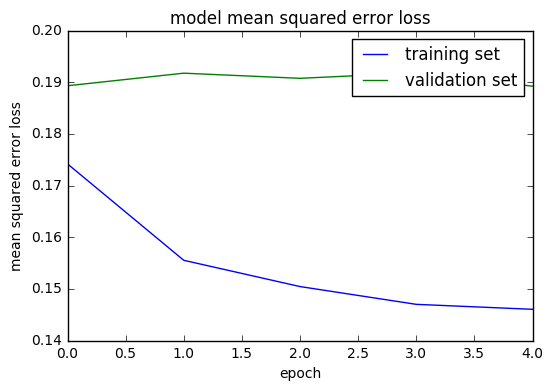

In [24]:
model = Nivdia()

train_samples, validation_samples = load_and_split_data('./data/', 
                                                        file_names=["0314", "0319-2"], 
                                                        load_three=False,
                                                        steer_left=0.04,
                                                        steer_right=0.04
                                                       )

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model.compile(loss='mse', optimizer="adam")

history_object = model.fit_generator(train_generator, samples_per_epoch= \
                len(train_samples), validation_data=validation_generator, 
                nb_val_samples=len(validation_samples), nb_epoch=5)

model.save("model-lenet-0322.h5")

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


In [ ]:
# samples = []
# data_dir = './data/track1/20170304/'
# with open(data_dir + 'driving_log.csv') as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         samples.append(line)

# train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# def generator(samples, batch_size=32):
#     num_samples = len(samples)
#     while 1: # Loop forever so the generator never terminates
#         shuffle(samples)
#         for offset in range(0, num_samples, batch_size):
#             batch_samples = samples[offset:offset+batch_size]

#             images = []
#             angles = []
#             for batch_sample in batch_samples:
#                 name = data_dir + './IMG/'+batch_sample[0].split('/')[-1]
#                 center_image = cv2.imread(name)
#                 center_angle = float(batch_sample[3])
#                 images.append(center_image)
#                 angles.append(center_angle)

#             # trim image to only see section with road
#             X_train = np.array(images)
#             y_train = np.array(angles)
#             yield sklearn.utils.shuffle(X_train, y_train)

In [ ]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
# validation_generator = generator(validation_samples, batch_size=32)

In [ ]:
for X_train in next(train_generator):
    len(X_train)